# Load Library

In [1]:
import pandas as pd
import numpy as np

In [2]:
train_sme = pd.read_csv("input/Training_SME_data.csv", index_col = 0,
                        parse_dates = ["date_activ", "date_end", "date_first_activ", "date_modif_prod", "date_renewal"])
train_target = pd.read_csv("input/Training_TARGET.csv")
train_price = pd.read_csv("input/Training_PRICE_hist.csv", parse_dates = ["price_date"])
test_sme = pd.read_csv("input/Test_SME_data.csv", index_col = 0, 
                        parse_dates = ["date_activ", "date_end", "date_first_activ", "date_modif_prod", "date_renewal"])
test_price = pd.read_csv("input/Test_PRICE_hist.csv", parse_dates = ["price_date"])

In [3]:
joined_train = train_sme.join(train_target.set_index("id"), how = "left", on = "id", sort = False)

# Basic EDA

In [ ]:
joined_train.head()

In [4]:
joined_train.shape

(16083, 35)

In [5]:
test_sme.shape

(4016, 34)

In [6]:
joined_train.select_dtypes(exclude = ["int64", "float64"]).columns

Index(['id', 'channel_sales', 'date_activ', 'date_end', 'date_first_activ',
       'date_modif_prod', 'date_renewal', 'has_gas', 'origin_up', 'isic_1l'],
      dtype='object')

In [7]:
joined_train.describe()

,campaign_disc_ele,cons_12m,cons_gas_12m,cons_last_month,forecast_base_bill_ele,forecast_base_bill_year,forecast_bill_12m,forecast_cons,forecast_cons_12m,forecast_cons_year,...,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,isic_2l,zip,churn
count,0.0,1.608300e+04,1.608300e+04,1.608300e+04,3503.000000,3503.000000,3503.000000,3503.000000,16083.000000,16083.000000,...,16083.000000,16070.000000,16070.000000,16083.000000,16068.000000,16083.000000,16080.000000,16083.000000,16083.000000,16083.000000
mean,NaN,1.948602e+05,3.191410e+04,1.947150e+04,336.194028,336.194028,3840.852534,207.083077,2371.328950,1907.928931,...,196.200073,22.463318,21.460549,1.347945,218.041126,5.030280,20.608722,56.334390,25891.719642,0.098738
std,NaN,6.797482e+05,1.776496e+05,8.238827e+04,649.789390,649.789390,5428.780279,455.911648,4036.347499,5259.170178,...,494.533188,23.708260,27.926788,1.460352,366.849718,1.676154,21.780167,24.933267,13381.988840,0.298319
min,NaN,-1.252760e+05,-3.037000e+03,-9.138600e+04,-364.940000,-364.940000,-2503.480000,0.000000,-16689.260000,-85627.000000,...,-9038.210000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000,1.000000,1002.000000,0.000000
25%,NaN,5.899000e+03,0.000000e+00,0.000000e+00,0.000000,0.000000,1158.190000,0.000000,513.280000,0.000000,...,0.000000,11.950000,11.950000,1.000000,51.970000,4.000000,12.500000,43.000000,15388.000000,0.000000
50%,NaN,1.533200e+04,0.000000e+00,9.000000e+02,163.020000,163.020000,2187.850000,42.240000,1179.750000,378.000000,...,44.510000,21.090000,20.970000,1.000000,119.725000,5.000000,13.856000,55.000000,27888.000000,0.000000
75%,NaN,5.018100e+04,0.000000e+00,4.125000e+03,396.205000,396.205000,4248.255000,228.195000,2692.495000,1995.000000,...,218.170000,29.640000,29.640000,1.000000,275.892500,6.000000,19.800000,78.000000,33888.000000,0.000000
max,NaN,1.609711e+07,4.188440e+06,4.538720e+06,12566.080000,12566.080000,81122.630000,9682.890000,103801.930000,175375.000000,...,15042.790000,374.640000,374.640000,32.000000,24570.650000,16.000000,500.000000,96.000000,50830.000000,1.000000


## Correlation

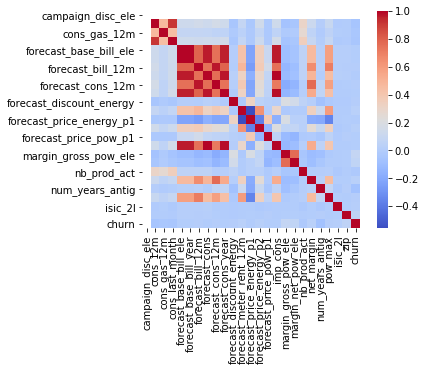

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.heatmap(joined_train.corr(),
            square = True, annot=False, cmap = "coolwarm")
plt.show()

We can see that several of the forecasted columns are highly correlated. The imp_cons column is also highly correlated to some of the forecasted columns. Since the forecasted columns will be dropped for modeling purpose, we will not have to deal with them at this time.

The columns cons_last_month and cons_12m are also correlated, which makes sense.

We can see that churn is not directly related to any single feature.

## Outliers

cons_12m


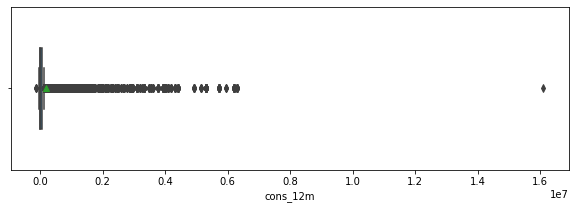

cons_gas_12m


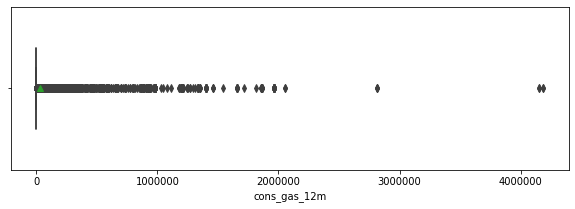

cons_last_month


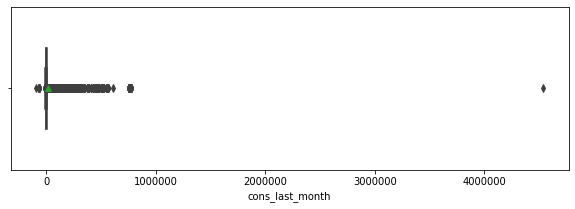

imp_cons


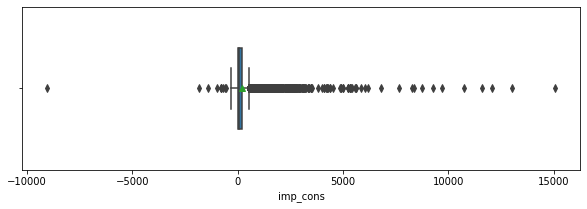

margin_gross_pow_ele


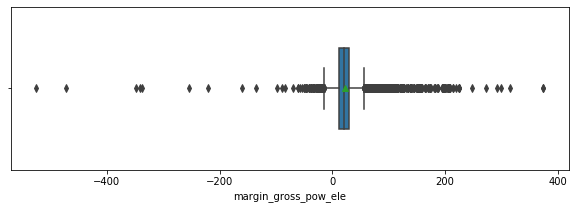

margin_net_pow_ele


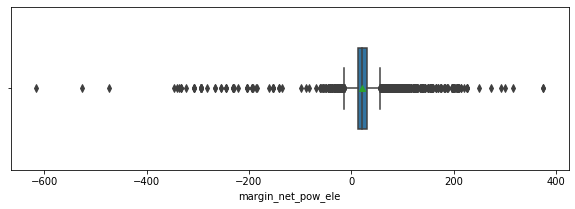

nb_prod_act


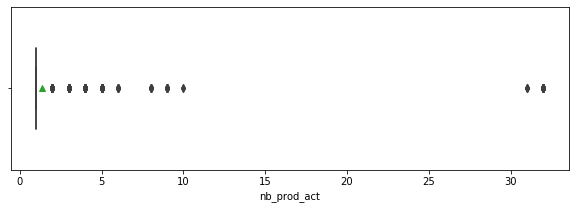

net_margin


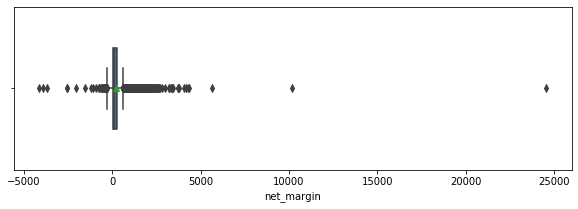

num_years_antig


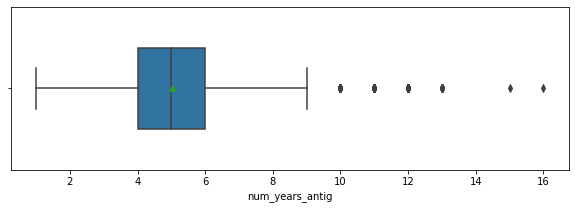

pow_max


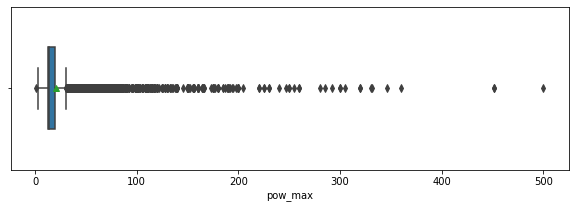

In [9]:
num_cols = ['cons_12m', 'cons_gas_12m', 'cons_last_month', 'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele',
            'nb_prod_act', 'net_margin', 'num_years_antig', 'pow_max']

for i in num_cols :
    print(i)
    fig, ax = plt.subplots(figsize = (10, 3))
    sns.boxplot(x = i, data = joined_train, width = 0.5, showmeans = True)
    plt.show()

# Data Cleaning

## Uninformative Columns

In [10]:
joined_train.nunique()[joined_train.nunique() <= 1]

campaign_disc_ele    0
dtype: int64

In [11]:
# drop uninformative columns
joined_train.drop(["campaign_disc_ele"], axis = 1, inplace = True)
test_sme.drop(["campaign_disc_ele"], axis = 1, inplace = True)

## Change Boolean Column to 0 & 1

In [12]:
joined_train["has_gas"] = joined_train["has_gas"].apply(lambda x: 1 if x == "t" else 0)
test_sme["has_gas"] = test_sme["has_gas"].apply(lambda x: 1 if x == "t" else 0)

## Change Categorical Variables to String

In [13]:
joined_train["isic_2l"] = joined_train["isic_2l"].astype(str)
joined_train["zip"] = joined_train["zip"].astype(str)

test_sme["isic_2l"] = test_sme["isic_2l"].astype(str)
test_sme["zip"] = test_sme["zip"].astype(str)

## Nulls

In [14]:
# get percentage of nulls
null_perc = joined_train.isnull().mean()
null_perc[null_perc > 0]

channel_sales               0.261954
date_end                    0.000124
date_first_activ            0.782192
date_modif_prod             0.009762
date_renewal                0.002487
forecast_base_bill_ele      0.782192
forecast_base_bill_year     0.782192
forecast_bill_12m           0.782192
forecast_cons               0.782192
forecast_discount_energy    0.007834
forecast_price_energy_p1    0.007834
forecast_price_energy_p2    0.007834
forecast_price_pow_p1       0.007834
margin_gross_pow_ele        0.000808
margin_net_pow_ele          0.000808
net_margin                  0.000933
origin_up                   0.005409
pow_max                     0.000187
dtype: float64

In [15]:
joined_train[null_perc[null_perc > 0].index.to_list()].dtypes

channel_sales                       object
date_end                    datetime64[ns]
date_first_activ            datetime64[ns]
date_modif_prod             datetime64[ns]
date_renewal                datetime64[ns]
forecast_base_bill_ele             float64
forecast_base_bill_year            float64
forecast_bill_12m                  float64
forecast_cons                      float64
forecast_discount_energy           float64
forecast_price_energy_p1           float64
forecast_price_energy_p2           float64
forecast_price_pow_p1              float64
margin_gross_pow_ele               float64
margin_net_pow_ele                 float64
net_margin                         float64
origin_up                           object
pow_max                            float64
dtype: object

### Fill Nulls of Categorical Variables

In [16]:
joined_train["channel_sales"] = joined_train["channel_sales"].fillna("other")
joined_train["origin_up"] = joined_train["origin_up"].fillna("none")

test_sme["channel_sales"] = test_sme["channel_sales"].fillna("other")
test_sme["origin_up"] = test_sme["origin_up"].fillna("none")

### Impute Nulls of Numerical Variables

In [17]:
# impute nulls for train dataset
joined_train["margin_gross_pow_ele"] = joined_train["margin_gross_pow_ele"]. \
                                                    fillna(joined_train.groupby(["isic_1l"])["margin_gross_pow_ele"]. \
                                                    transform("median"))

joined_train["margin_net_pow_ele"] = joined_train["margin_net_pow_ele"]. \
                                                fillna(joined_train.groupby(["isic_1l"])["margin_net_pow_ele"]. \
                                                transform("median"))

joined_train["net_margin"] = joined_train["net_margin"]. \
                                            fillna(joined_train.groupby(["isic_1l"])["net_margin"]. \
                                            transform("mean"))

joined_train["pow_max"] = joined_train["pow_max"]. \
                                        fillna(joined_train.groupby(["isic_1l"])["pow_max"]. \
                                        transform("median"))

# impute nulls for test dataset
test_sme["margin_gross_pow_ele"] = test_sme["margin_gross_pow_ele"]. \
                                            fillna(test_sme.groupby(["isic_1l"])["margin_gross_pow_ele"]. \
                                            transform("median"))

test_sme["margin_net_pow_ele"] = test_sme["margin_net_pow_ele"]. \
                                        fillna(test_sme.groupby(["isic_1l"])["margin_net_pow_ele"]. \
                                        transform("median"))

test_sme["net_margin"] = test_sme["net_margin"]. \
                                fillna(test_sme.groupby(["isic_1l"])["net_margin"]. \
                                transform("mean"))

test_sme["pow_max"] = test_sme["pow_max"]. \
                            fillna(test_sme.groupby(["isic_1l"])["pow_max"]. \
                            transform("median"))

### Impute Nulls for Dates

In [18]:
# fill nulls for dates in training dataset
joined_train["date_modif_prod"].fillna(joined_train["date_activ"], inplace = True)
joined_train["date_renewal"].fillna(joined_train["date_modif_prod"], inplace = True)
joined_train["date_end"].fillna(joined_train["date_renewal"], inplace = True)

# fill nulls for dates in test dataset
test_sme["date_modif_prod"].fillna(test_sme["date_activ"], inplace = True)
test_sme["date_renewal"].fillna(test_sme["date_modif_prod"], inplace = True)
test_sme["date_end"].fillna(test_sme["date_renewal"], inplace = True)

In [19]:
# flag nans for customers without date_first_activ
joined_train["date_first_activ"] = joined_train["date_first_activ"].apply(lambda x: 1 if x == x else 0).sum()
joined_train.drop(["date_first_activ"], axis = 1, inplace = True)

test_sme["date_first_activ"] = test_sme["date_first_activ"].apply(lambda x: 1 if x == x else 0).sum()
test_sme.drop(["date_first_activ"], axis = 1, inplace = True)

# Clean Price History Data

In [20]:
train_price.isnull().sum()

id                 0
price_date         0
price_p1_var    1359
price_p2_var    1359
price_p3_var    1359
price_p1_fix    1359
price_p2_fix    1359
price_p3_fix    1359
dtype: int64

In [21]:
# create rows for missing months
train_price = train_price.set_index(['id', 'price_date']).unstack().stack(dropna=False).reset_index()
test_price = test_price.set_index(['id', 'price_date']).unstack().stack(dropna=False).reset_index()

In [22]:
# Change price_p1_var, price_p2_var, price_p3_var missing values (0.7%, 1359) into '0'
train_price[train_price['price_date'].dt.month >= 2] = train_price[train_price['price_date'].dt.month >= 2]. \
                                                                    fillna(method='ffill')
train_price[train_price['price_date'].dt.month <= 2] = train_price[train_price['price_date'].dt.month <= 2]. \
                                                                    fillna(method='bfill')

test_price[test_price['price_date'].dt.month >= 2] = test_price[test_price['price_date'].dt.month >= 2]. \
                                                                fillna(method='ffill')
test_price[test_price['price_date'].dt.month <= 2] = test_price[test_price['price_date'].dt.month <= 2]. \
                                                                fillna(method='bfill')

# Merge Data

In [23]:
# drop churn column before merging data
joined_train = joined_train.drop(["churn"], axis = 1)

In [24]:
# pivot data so that each row corresponds to a unique ID
train_price["price_date"] = train_price["price_date"].dt.month.astype(str)
train_price["price_date"] = train_price["price_date"].apply(lambda x : ("0" + x) if (len(x) == 1) else x)
train_price = train_price.pivot(index="id", columns = "price_date", 
                                values = ["price_p1_var", "price_p2_var", "price_p3_var", "price_p1_fix",
                                          "price_p2_fix", "price_p3_fix"])
train_price.columns = ["_".join(col).rstrip() for col in train_price.columns.values]
train_price = train_price.reset_index()

test_price["price_date"] = test_price["price_date"].dt.month.astype(str)
test_price["price_date"] = test_price["price_date"].apply(lambda x : ("0" + x) if (len(x) == 1) else x)
test_price = test_price.pivot(index="id", columns = "price_date",
                              values = ["price_p1_var", "price_p2_var", "price_p3_var", "price_p1_fix",
                                        "price_p2_fix", "price_p3_fix"])
test_price.columns = ["_".join(col).rstrip() for col in test_price.columns.values]
test_price = test_price.reset_index()

In [25]:
print("Train SME Data rows:", joined_train.shape)
print("Train Price Data rows:", train_price.shape)
print("Train Price Data rows:", train_target.shape)

Train SME Data rows: (16083, 32)
Train Price Data rows: (16096, 73)
Train Price Data rows: (16096, 2)


In [26]:
# join train set
train_df = joined_train.join(train_price.set_index(["id"]), how = "left", on = "id", sort = False)
train_df = train_df.join(train_target.set_index(["id"]), how = "left", on = "id", sort = False)

In [27]:
# check join is done properly
print("Same rows in SME and in joined dataset?", joined_train.shape[0] == train_df.shape[0])

Same rows in SME and in joined dataset? True


In [28]:
# join test set
test_df = test_sme.join(test_price.set_index(["id"]), how = "left", on = "id", sort = False)

In [29]:
# check join is done properly
print("Same rows in SME and in joined dataset?", test_sme.shape[0] == test_df.shape[0])

Same rows in SME and in joined dataset? True


# Export to Financial

In [30]:
# export data prior to dropping forecast columns
train_df.to_csv("input/finance_train_df_v2.csv", index = False)

# Drop Forecasted Columns for Modeling

In [31]:
train_df.drop(["forecast_base_bill_ele", "forecast_base_bill_year","forecast_bill_12m",
               "forecast_cons", "forecast_discount_energy","forecast_price_energy_p1",
               "forecast_price_energy_p2", "forecast_price_pow_p1", "forecast_cons_12m",
               "forecast_cons_year", "forecast_meter_rent_12m"],
              axis = 1,
              inplace = True)

test_df.drop(["forecast_base_bill_ele", "forecast_base_bill_year","forecast_bill_12m",
              "forecast_cons", "forecast_discount_energy","forecast_price_energy_p1",
              "forecast_price_energy_p2", "forecast_price_pow_p1", "forecast_cons_12m",
              "forecast_cons_year", "forecast_meter_rent_12m"],
             axis = 1,
             inplace = True)

# Export Cleaned Data

In [32]:
# export data prior to dropping forecast columns
train_df.to_csv("input/train_df_clean_v2.csv", index = False)
test_df.to_csv("input/test_df_clean_v2.csv", index = False)